ランタイム > ランタイムタイプの変更 > ハードウェアアクセラレータ
から，GPUを指定してください．

Google Driveをマウントするために，下のセルを実行してURLをクリックし，出てきたコードを貼り付けてEnterを押してください．




In [1]:
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from google.colab import drive, files
from PIL import Image
from torchvision import transforms,models
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


Google Driveからファイルをコピーします．
初回のみ10分程度時間がかかります．


In [2]:
# ファイルコピー
if not os.path.exists("/content/kueeml2020_data_2/train_input.json"):
    !rsync --progress /content/drive/MyDrive/kuee-ml-2020/kueeml2020_data_2.tar /content/ 

    # rsync: change_dir "/content/drive/MyDrive/kuee-ml-2020" failed: No such file or directory (2) が出る場合，
    # まず，データセット申請のGoogleフォームに登録したメールアドレスでログインしていることを確認してください．
    # 次に，Googleフォームに登録したメールアドレスの受信ボックスを見て，Google Driveからのメールを見て開くボタンを押してください．
    # 次に，ColabにログインしているアカウントでGoogle Driveを開き，
    # 左の「共有アイテム」を押すと「kuee-ml-2020」があることを確認してください．
    # 次に，「マイドライブ」にkuee-ml-2020へのショートカットがあるか確認してください．
    # なければ，共有アイテムから「ドライブにショートカットを追加」でマイドライブにショートカットを作成してください． 
    # そして，画面左のファイル一覧で，drive/MyDrive/kuee-ml-2020 があることを確認してください． 

    # また，2行目を下の行に置き換えるとうまくいく場合があります．
    # !rsync --progress /content/drive/MyDrive/kuee_ml_2020/kueeml2020_data.tar /content/ 
    # それでもうまく行かない場合は，どこまで確認できたかと，スクリーンショットを添えて質問メールを送ってください．2021/1/17 追記

    # データを変更しました．
    # 2021/1/18 追記
    print("copied.")
    !tar -xvf /content/kueeml2020_data_2.tar
    print("extracted.")

ストリーミング出力は最後の 5000 行に切り捨てられました。
kueeml2020_data/kueeml2020_train/376/139376.JPG
kueeml2020_data/kueeml2020_train/376/84376.JPG
kueeml2020_data/kueeml2020_train/882/
kueeml2020_data/kueeml2020_train/882/30882.JPG
kueeml2020_data/kueeml2020_train/882/73882.JPG
kueeml2020_data/kueeml2020_train/882/53882.JPG
kueeml2020_data/kueeml2020_train/882/20882.JPG
kueeml2020_data/kueeml2020_train/882/94882.JPG
kueeml2020_data/kueeml2020_train/882/59882.JPG
kueeml2020_data/kueeml2020_train/882/44882.JPG
kueeml2020_data/kueeml2020_train/882/144882.JPG
kueeml2020_data/kueeml2020_train/882/18882.JPG
kueeml2020_data/kueeml2020_train/882/91882.JPG
kueeml2020_data/kueeml2020_train/882/115882.JPG
kueeml2020_data/kueeml2020_train/882/101882.JPG
kueeml2020_data/kueeml2020_train/882/124882.JPG
kueeml2020_data/kueeml2020_train/882/136882.JPG
kueeml2020_data/kueeml2020_train/882/65882.JPG
kueeml2020_data/kueeml2020_train/882/143882.JPG
kueeml2020_data/kueeml2020_train/403/
kueeml2020_data/kueeml2020_train/403/47

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
if device=='cuda':
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def worker_init_fn(worker_id):
    random.seed(worker_id)
    np.random.seed(worker_id)


In [4]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class MushroomDataset(torch.utils.data.Dataset):
    def __init__(self, json_file, root_dir, transform=None, is_train=False):
        assert os.path.exists(json_file), f"{json_file} does not exists"
        assert os.path.exists(root_dir), f"{root_dir} does not exists"
        with open(json_file) as f:
            self.annotations = json.load(f)
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        file_path = os.path.join(self.root_dir, ann["file_path"])
        # sample = {"image": io.imread(file_path), "id": ann["id"]}
        image = Image.open(file_path)
        image_id = ann["id"]
        if self.is_train:
            label = ann["category_id"]
        else:
            label = -1
        image = self.transform(image)
        return image, image_id, label

BASE_PATH = "/content/kueeml2020_data"
TRAIN_JSON_PATH = os.path.join(BASE_PATH, "train_input.json")
TEST_JSON_PATH = os.path.join(BASE_PATH, "test_input.json")

test_preprocess = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    # transforms.RandomCrop(56),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize((0.5,),(0.5,)),
])

train_preprocess = transforms.Compose([
    transforms.Resize(512),
    # transforms.Resize(64),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    # transforms.CenterCrop(28),
    transforms.CenterCrop(448),
    # transforms.RandomCrop(448),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize((0.5,),(0.5,)),
])

batch_size = 128
learning_rate = 0.001
num_classes = 100
# エポック数を少なくしました． 2021/01/18 追記
num_epochs = 30

In [25]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split

train_ds = MushroomDataset(TRAIN_JSON_PATH, BASE_PATH, is_train=True, transform=train_preprocess)
test_ds = MushroomDataset(TEST_JSON_PATH, BASE_PATH, is_train=False, transform=test_preprocess)

train_index, valid_index = train_test_split(range(len(train_ds)), test_size=0.1)
train_dataset = Subset(train_ds, train_index)
valid_dataset   = Subset(train_ds, valid_index)

train_dl = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=2,
                                           worker_init_fn=worker_init_fn)
valid_dl = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False,
                                           num_workers=2,
                                           worker_init_fn=worker_init_fn)
test_dl = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=2,
                                          worker_init_fn=worker_init_fn)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([448, 448, 3])


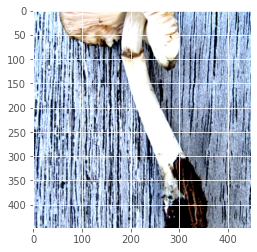

In [26]:
# train_loader = DataLoader(test_ds, batch_size=128, shuffle=True)
data_iter = iter(test_dl)
imgs = data_iter.next()
img = imgs[0]
imga = img[6]
img_permute = imga.permute(1, 2, 0)
img_permute = 0.5 * img_permute + 0.5
# img_permute = np.clip(img_permute, 0, 1)
print(img_permute.size())
plt.imshow(img_permute)


In [7]:
class NeuralNet(torch.nn.Module):
    # 参考実装が間違っていました．すみません． 2021/01/17 追記
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(input_size, hidden_size) 
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)  
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)  
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)  
        self.fc5 = torch.nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

model = NeuralNet(28*28*3,1000, num_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [34]:
from torchvision import models

In [40]:
model = models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
                      nn.Linear(2048, 1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),
                      nn.Linear(1024,1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),
                      nn.Linear(1024,1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),
                      # nn.Linear(512, 256),
                      # nn.BatchNorm1d(256),
                      # nn.ReLU(),
                      nn.Linear(1024,num_classes))

In [41]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
criterion = torch.nn.CrossEntropyLoss()
learning_rate=0.0008
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
import torch.nn as nn
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2),

            # nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            # nn.BatchNorm2d(32),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            

            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2),

            # nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(p=0.3),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(p=0.3),

            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),
            # nn.Dropout2d(p=0.3),
            # nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
        )
        self.classifier1 = nn.Linear(in_features=7 * 7 * 256, out_features=512)
        self.dropout = nn.Dropout(p=0.5)
        self.classifier2 = nn.Linear(in_features=512, out_features=256)
        self.classifier3 = nn.Linear(in_features=256, out_features=num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier1(x)
        x = self.dropout(x)
        x = self.classifier2(x)
        x = self.dropout(x)
        x = self.classifier3(x)
        return x
  

model = CNN(num_classes)
criterion = torch.nn.CrossEntropyLoss()
# learning_rate=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# learning_rate=0.0001
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [43]:
model = model.to(device)
total_step = len(train_dl)
train_losses=[]
valid_losses=[]
train_accs=[]
val_accs=[]
# learning_rate=0.0001
num_epochs=10

for epoch in range(num_epochs):
    train_correct=0
    valid_correct=0
    model.train()
    train_loss=0
    valid_loss=0
    for i, (images, image_ids, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # train_losses += loss/item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if (i+1) % 5 == 0:
        #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        #            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            # losses.append(loss)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
    train_loss /= total_step 
    train_losses.append(train_loss)
    print("Train Loss: {}  acc:{:.4f}%".format(train_loss,100*train_correct/len(train_dl.dataset)))
    train_accs.append(train_correct/len(train_dl.dataset))

    model.eval()
    for i, (images, image_ids, labels) in enumerate(valid_dl):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss +=  loss.item()
        _, predicted = torch.max(outputs.data, 1) 
        valid_correct += (predicted == labels).sum().item()
    valid_loss /= len(valid_dl)
    valid_losses.append(valid_loss)
    print("Valid Loss: {}  acc:{:.4f}%".format(valid_loss,100*valid_correct/len(valid_dl.dataset)))
    val_accs.append(valid_correct/len(valid_dl.dataset))

Epoch [1/10], Step [10/95], Loss: 3.5847


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1/10], Step [20/95], Loss: 2.9990
Epoch [1/10], Step [30/95], Loss: 2.4388
Epoch [1/10], Step [40/95], Loss: 2.1699
Epoch [1/10], Step [50/95], Loss: 2.0596
Epoch [1/10], Step [60/95], Loss: 2.0970
Epoch [1/10], Step [70/95], Loss: 2.1835
Epoch [1/10], Step [80/95], Loss: 1.7639
Epoch [1/10], Step [90/95], Loss: 1.6256
Train Loss: 2.4630475383055837  acc:38.1987%
Valid Loss: 1.9984633272344416  acc:47.2593%
Epoch [2/10], Step [10/95], Loss: 1.4353
Epoch [2/10], Step [20/95], Loss: 1.4840
Epoch [2/10], Step [30/95], Loss: 1.4977
Epoch [2/10], Step [40/95], Loss: 1.5474
Epoch [2/10], Step [50/95], Loss: 1.4258
Epoch [2/10], Step [60/95], Loss: 1.2259
Epoch [2/10], Step [70/95], Loss: 1.6825


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2/10], Step [80/95], Loss: 1.4686
Epoch [2/10], Step [90/95], Loss: 1.3432
Train Loss: 1.5148271159121864  acc:57.4051%
Valid Loss: 1.6237563219937412  acc:53.5556%
Epoch [3/10], Step [10/95], Loss: 1.1725


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3/10], Step [20/95], Loss: 1.2112
Epoch [3/10], Step [30/95], Loss: 1.0437
Epoch [3/10], Step [40/95], Loss: 1.1504
Epoch [3/10], Step [50/95], Loss: 1.1743
Epoch [3/10], Step [60/95], Loss: 1.5423
Epoch [3/10], Step [70/95], Loss: 1.2295
Epoch [3/10], Step [80/95], Loss: 1.2204
Epoch [3/10], Step [90/95], Loss: 1.2195
Train Loss: 1.2351194977760316  acc:64.6662%
Valid Loss: 1.7278567986054854  acc:51.8519%
Epoch [4/10], Step [10/95], Loss: 0.9158
Epoch [4/10], Step [20/95], Loss: 0.8652


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4/10], Step [30/95], Loss: 1.0890
Epoch [4/10], Step [40/95], Loss: 0.9971
Epoch [4/10], Step [50/95], Loss: 1.0789
Epoch [4/10], Step [60/95], Loss: 1.1782
Epoch [4/10], Step [70/95], Loss: 1.0550
Epoch [4/10], Step [80/95], Loss: 1.0358
Epoch [4/10], Step [90/95], Loss: 0.9508
Train Loss: 1.0185630001519856  acc:69.3258%
Valid Loss: 1.5917316566814075  acc:55.2593%
Epoch [5/10], Step [10/95], Loss: 0.9435
Epoch [5/10], Step [20/95], Loss: 0.7459


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5/10], Step [30/95], Loss: 0.6507
Epoch [5/10], Step [40/95], Loss: 0.7913
Epoch [5/10], Step [50/95], Loss: 0.9967
Epoch [5/10], Step [60/95], Loss: 0.8526
Epoch [5/10], Step [70/95], Loss: 0.8520
Epoch [5/10], Step [80/95], Loss: 0.9561
Epoch [5/10], Step [90/95], Loss: 0.7969
Train Loss: 0.8534681935059397  acc:74.2817%
Valid Loss: 1.64862352067774  acc:54.3704%
Epoch [6/10], Step [10/95], Loss: 0.6989
Epoch [6/10], Step [20/95], Loss: 0.5698
Epoch [6/10], Step [30/95], Loss: 0.6847
Epoch [6/10], Step [40/95], Loss: 0.7334


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6/10], Step [50/95], Loss: 0.7858
Epoch [6/10], Step [60/95], Loss: 0.7313
Epoch [6/10], Step [70/95], Loss: 0.7458
Epoch [6/10], Step [80/95], Loss: 0.9450
Epoch [6/10], Step [90/95], Loss: 0.8900
Train Loss: 0.7336128768167998  acc:77.6982%
Valid Loss: 1.5697102329947732  acc:58.0000%
Epoch [7/10], Step [10/95], Loss: 0.4633
Epoch [7/10], Step [20/95], Loss: 0.7611
Epoch [7/10], Step [30/95], Loss: 0.6463
Epoch [7/10], Step [40/95], Loss: 0.5921
Epoch [7/10], Step [50/95], Loss: 0.6224
Epoch [7/10], Step [60/95], Loss: 0.4748
Epoch [7/10], Step [70/95], Loss: 0.4919
Epoch [7/10], Step [80/95], Loss: 0.6586


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7/10], Step [90/95], Loss: 0.7443
Train Loss: 0.6324675864294955  acc:80.5960%
Valid Loss: 1.60069739818573  acc:57.2593%


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8/10], Step [10/95], Loss: 0.4578
Epoch [8/10], Step [20/95], Loss: 0.4450
Epoch [8/10], Step [30/95], Loss: 0.5009
Epoch [8/10], Step [40/95], Loss: 0.4258
Epoch [8/10], Step [50/95], Loss: 0.4524
Epoch [8/10], Step [60/95], Loss: 0.5357
Epoch [8/10], Step [70/95], Loss: 0.5532
Epoch [8/10], Step [80/95], Loss: 0.5984
Epoch [8/10], Step [90/95], Loss: 0.5858
Train Loss: 0.5288818983655227  acc:83.7902%
Valid Loss: 1.5038111426613547  acc:60.5185%
Epoch [9/10], Step [10/95], Loss: 0.5092
Epoch [9/10], Step [20/95], Loss: 0.3659
Epoch [9/10], Step [30/95], Loss: 0.4315


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9/10], Step [40/95], Loss: 0.5178
Epoch [9/10], Step [50/95], Loss: 0.3883
Epoch [9/10], Step [60/95], Loss: 0.6566
Epoch [9/10], Step [70/95], Loss: 0.5679
Epoch [9/10], Step [80/95], Loss: 0.3312
Epoch [9/10], Step [90/95], Loss: 0.4520
Train Loss: 0.46297931922109503  acc:85.6837%
Valid Loss: 1.5985925956205889  acc:58.5926%
Epoch [10/10], Step [10/95], Loss: 0.3033
Epoch [10/10], Step [20/95], Loss: 0.4100
Epoch [10/10], Step [30/95], Loss: 0.3731
Epoch [10/10], Step [40/95], Loss: 0.4222
Epoch [10/10], Step [50/95], Loss: 0.4476
Epoch [10/10], Step [60/95], Loss: 0.3263
Epoch [10/10], Step [70/95], Loss: 0.4468
Epoch [10/10], Step [80/95], Loss: 0.4355


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [10/10], Step [90/95], Loss: 0.5734
Train Loss: 0.4098143718744579  acc:87.2150%
Valid Loss: 1.505545670335943  acc:61.1111%


In [ ]:
labels

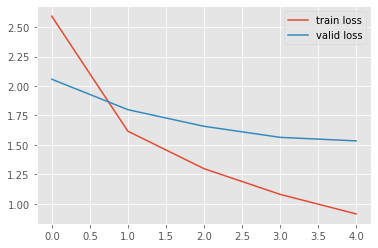

In [34]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
# plt.scatter(np.linspace(1,len(losses),1),losses)
# plt.yscale("log")
plt.plot(train_losses,label="train loss")
plt.plot(valid_losses,label="valid loss")
# plt.plot(losses2,label="lr=0.0008")
plt.legend()

In [35]:
len(train_dl.dataset)

12147

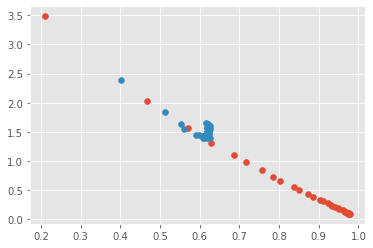

In [76]:
plt.scatter(train_accs,train_losses)
plt.scatter(val_accs,valid_losses)

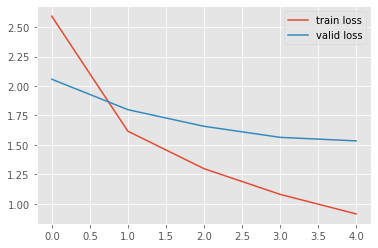

In [36]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
# plt.scatter(np.linspace(1,len(losses),1),losses)
# plt.yscale("log")
plt.plot(train_losses,label="train loss")
plt.plot(valid_losses,label="valid loss")
# plt.plot(losses2,label="lr=0.0008")
plt.legend()

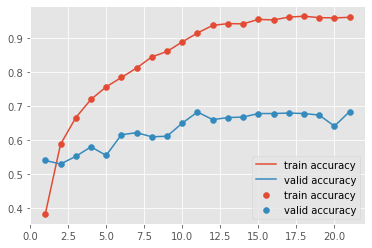

In [21]:
plt.scatter(np.linspace(1,len(train_accs),len(train_accs)),train_accs,label="train accuracy")
plt.scatter(np.linspace(1,len(train_accs),len(train_accs)),val_accs,label="valid accuracy")
plt.plot(np.linspace(1,len(train_accs),len(train_accs)),train_accs,label="train accuracy")
plt.plot(np.linspace(1,len(train_accs),len(train_accs)),val_accs,label="valid accuracy")
plt.legend()

In [22]:
model.eval()
test_correct=0
with torch.no_grad():
    submission = []
    for i, (images, image_ids, _) in enumerate(test_dl):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) 
        for img_id, pred in zip(image_ids, predicted.cpu().detach()):
            submission.append((img_id.item(), pred.item()))

In [23]:
submission_file = "/content/submission.csv"
with open(submission_file, "w") as f:
    f.write("id,predicted\n")
    for sub in submission:
        f.write(f"{sub[0]},{sub[1]}\n")


In [24]:
files.download(submission_file) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [181]:
len(test_dl.dataset)

300

In [ ]:
for i, (images, image_ids, _) in enumerate(test_dl):
        for img_id, pred in zip(image_ids, predicted.cpu().detach()):
            print(pred.item(),labels[1])

In [ ]:
for i in enumerate(labels):
    print(i)

In [56]:
# train_loader = DataLoader(test_ds, batch_size=128, shuffle=True)
data_iter = iter(test_dl)
imgs = data_iter.next()
img = imgs[0]
imga = img[1]
img_permute = imga.permute(1, 2, 0)
img_permute = 0.5 * img_permute + 0.5
# img_permute = np.clip(img_permute, 0, 1)
print(img_permute.size())
plt.imshow(img_permute)


ValueError: ignored